In [2]:
import os, json, zipfile, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

with zipfile.ZipFile("/content/house-prices-advanced-regression-techniques.zip","r") as z:
    z.extract("train.csv", path="/content")

df = pd.read_csv("/content/train.csv")
print("Raw shape:", df.shape)
df.head(3)


Raw shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["SalePrice", "Id"]]

X = df[numeric_cols].copy()
y = df["SalePrice"].values.astype(float)

# Impute NaNs (mean) and standardize X for better conditioning
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/val split (we optimize on train; val is unused in HW but kept for sanity)
Xtr, Xte, ytr, yte = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Add bias term (column of ones)
Xtr = np.hstack([np.ones((Xtr.shape[0],1)), Xtr])
Xte = np.hstack([np.ones((Xte.shape[0],1)), Xte])

n, d = Xtr.shape
print(f"Train shape: {Xtr.shape}  Test shape: {Xte.shape}")

# Objective (1/(2n)) * ||Xw - y||^2 and gradient
def f_obj(w, X, y):
    r = X @ w - y
    return 0.5/len(y) * (r @ r)

def grad(w, X, y):
    r = X @ w - y
    return (X.T @ r) / len(y)

Train shape: (1168, 37)  Test shape: (292, 37)


In [4]:
#Line Searches
def phi(t, w, p, X, y):
    return f_obj(w + t*p, X, y)

def backtracking_alpha_beta(w, p, X, y, alpha=1e-4, beta=0.5, t_init=1.0):
    """
    Armijo backtracking: find t > 0 s.t.
    f(w + t p) <= f(w) + alpha * t * grad(w)^T p
    """
    t = t_init
    fw = f_obj(w, X, y)
    g = grad(w, X, y)
    gTp = g @ p
    # Ensure descent direction
    if gTp > 0:
        p = -g
        gTp = - (g @ g)
    # Shrink until Armijo holds
    while f_obj(w + t*p, X, y) > fw + alpha * t * gTp:
        t *= beta
        if t < 1e-16:  # guard
            break
    return t

def ternary_search_step(w, p, X, y, T_init=1.0, eps=1e-5, growth=2.0, max_doubles=30):
    """
    Ternary search along t in [0, T] for unimodal phi(t).
    1) Bracket by doubling T until phi starts increasing (or max_doubles reached).
    2) Ternary search on [0, T].
    """
    # Ensure descent direction
    g = grad(w, X, y)
    if g @ p > 0:
        p = -g

    # Bracketing: expand R until phi(R) >= phi(prev_R)
    L, R = 0.0, T_init
    prev_val = phi(L, w, p, X, y)
    curr_val = phi(R, w, p, X, y)
    doubles = 0
    while curr_val < prev_val and doubles < max_doubles:
        prev_val = curr_val
        R *= growth
        curr_val = phi(R, w, p, X, y)
        doubles += 1
    # Now [0, R] should bracket minimum (under unimodality/convexity along p)
    # Ternary search
    while R - L > eps:
        m1 = L + (R - L)/3.0
        m2 = R - (R - L)/3.0
        f1 = phi(m1, w, p, X, y)
        f2 = phi(m2, w, p, X, y)
        if f1 < f2:
            R = m2
        else:
            L = m1
    return 0.5*(L+R)


In [5]:
#GD

def gradient_descent(X, y, max_iters=5000, tol=1e-8, ls_method="backtracking",
                     alpha=1e-4, beta=0.5, t_init=1.0, T_init=1.0, eps_ternary=1e-6,
                     record_every=1, verbose=False):
    """
    ls_method: 'backtracking' or 'ternary'
    Returns: dict with history for plotting & stats
    """
    n, d = X.shape
    w = np.zeros(d)  # start at zero (after standardization)
    hist = {"f": [], "time": [], "w": [], "iters": 0}
    t0 = time.perf_counter()
    f_prev = f_obj(w, X, y)
    for k in range(1, max_iters+1):
        g = grad(w, X, y)
        p = -g
        if ls_method == "backtracking":
            t = backtracking_alpha_beta(w, p, X, y, alpha=alpha, beta=beta, t_init=t_init)
        elif ls_method == "ternary":
            t = ternary_search_step(w, p, X, y, T_init=T_init, eps=eps_ternary)
        else:
            raise ValueError("Unknown ls_method")

        w = w + t * p
        f_curr = f_obj(w, X, y)

        if k % record_every == 0:
            hist["f"].append(f_curr)
            hist["time"].append(time.perf_counter() - t0)
            hist["w"].append(w.copy())

        if verbose and k % 100 == 0:
            print(f"[{ls_method}] iter {k}: f={f_curr:.6e}, step={t:.3e}, ||g||={np.linalg.norm(g):.3e}")

        # stopping
        if abs(f_prev - f_curr) < tol:
            hist["iters"] = k
            # ensure last point is recorded
            if (k % record_every) != 0:
                hist["f"].append(f_curr)
                hist["time"].append(time.perf_counter() - t0)
                hist["w"].append(w.copy())
            break
        f_prev = f_curr

    else:
        hist["iters"] = max_iters
        # ensure last point is recorded
        if (max_iters % record_every) != 0:
            hist["f"].append(f_curr)
            hist["time"].append(time.perf_counter() - t0)
            hist["w"].append(w.copy())

    hist["final_f"] = hist["f"][-1]
    hist["total_time"] = hist["time"][-1]
    hist["w_final"] = hist["w"][-1]
    return hist

# Run both methods
bt_hist = gradient_descent(
    Xtr, ytr, max_iters=5000, tol=1e-10,
    ls_method="backtracking", alpha=1e-4, beta=0.5, t_init=1.0,
    record_every=1, verbose=False
)

ts_hist = gradient_descent(
    Xtr, ytr, max_iters=5000, tol=1e-10,
    ls_method="ternary", T_init=1.0, eps_ternary=1e-7,
    record_every=1, verbose=False
)

print("Backtracking: iters =", bt_hist["iters"], "time(s) =", round(bt_hist["total_time"], 4), "final f =", bt_hist["final_f"])
print("Ternary     : iters =", ts_hist["iters"], "time(s) =", round(ts_hist["total_time"], 4), "final f =", ts_hist["final_f"])


Backtracking: iters = 462 time(s) = 0.2154 final f = 575501542.6202453
Ternary     : iters = 486 time(s) = 1.3594 final f = 575501542.6202317


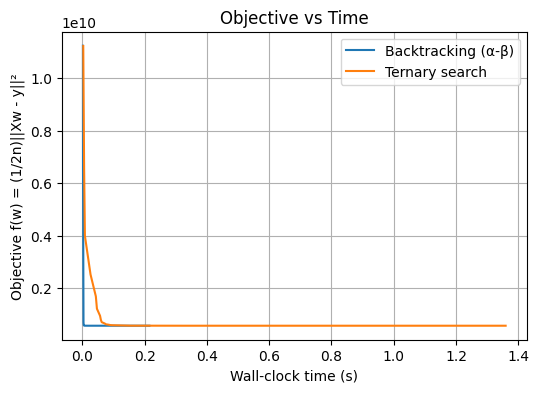

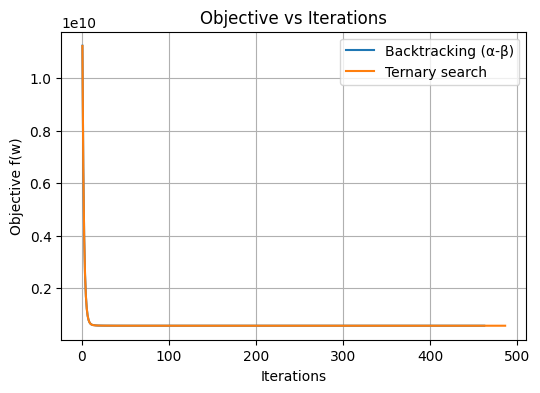

In [6]:
#plots
plt.figure(figsize=(6,4))
plt.plot(bt_hist["time"], bt_hist["f"], label="Backtracking (α-β)")
plt.plot(ts_hist["time"], ts_hist["f"], label="Ternary search")
plt.xlabel("Wall-clock time (s)")
plt.ylabel("Objective f(w) = (1/2n)||Xw - y||²")
plt.title("Objective vs Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(bt_hist["f"])+1), bt_hist["f"], label="Backtracking (α-β)")
plt.plot(range(1, len(ts_hist["f"])+1), ts_hist["f"], label="Ternary search")
plt.xlabel("Iterations")
plt.ylabel("Objective f(w)")
plt.title("Objective vs Iterations")
plt.legend()
plt.grid(True)
plt.show()
